In [ ]:
# !pip install numpy pandas seaborn matplotlib scikit-learn safetensors
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# # reben requiring python > 3.9  but < 3.12
# !pip install git+https://git.tu-berlin.de/rsim/reben-training-scripts.git
# !pip install configilm torchsummary

In [1]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np

### try passing input to model

In [1]:
from reben_publication.BigEarthNetv2_0_ImageClassifier import BigEarthNetv2_0_ImageClassifier

model = BigEarthNetv2_0_ImageClassifier.from_pretrained("BIFOLD-BigEarthNetv2-0/resnet101-s2-v0.1.1")

/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/configilm/ConfigILM.py:134: UserWarning: Keyword 'img_size' unknown. Trying to ignore and restart creation.
  warnings.warn(f"Keyword '{failed_kw}' unknown. Trying to ignore and restart creation.")


Image: map_114.tif, Class ID: 8, Probability: 0.9865127801895142
Image: map_114.tif, Class ID: 9, Probability: 0.011682773008942604
Image: map_114.tif, Class ID: 0, Probability: 0.0011730528203770518
Image: map_114.tif, Class ID: 2, Probability: 0.00019167228310834616
Image: map_114.tif, Class ID: 4, Probability: 0.00014380131324287504


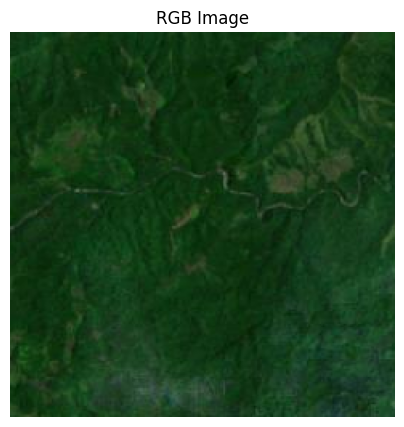

In [89]:
import os
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import timm

# Set the path to your folder containing multispectral images
image_folder = 'data/daysat/2022'


# Define manual preprocessing transformations
def preprocess_image(image_array):
    # Resize and crop the image
    image = Image.fromarray(image_array)
    image = image.resize((256, 256), Image.BILINEAR)
    
    # Center crop
    width, height = image.size
    left = (width - 224) / 2
    top = (height - 224) / 2
    right = (width + 224) / 2
    bottom = (height + 224) / 2
    image = image.crop((left, top, right, bottom))
    
    # Convert to tensor and normalize
    image_tensor = transforms.ToTensor()(image)  # Convert to tensor
    image_tensor = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Example mean values for RGB
        std=[0.229, 0.224, 0.225]
    )(image_tensor)
    
    return image_tensor

# Load a pretrained ResNet model from timm, modified for 10 channels
model = timm.create_model('resnet50', pretrained=True, num_classes=10)
# Modify the first convolutional layer to accept 10 channels
model.conv1 = torch.nn.Conv2d(10, model.conv1.out_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.eval()  # Set the model to evaluation mode

# Load images from the folder and run them through the model
for j,image_name in enumerate(os.listdir(image_folder)):
    if j == 1:
        break
    if image_name.endswith('.tif'):  # Ensure it's a tif image
        # Load the image and convert to a NumPy array
        image_path = os.path.join(image_folder, image_name)
        image = np.array(Image.open(image_path))
        
        # Check the number of channels
        if image.shape[2] < 10:
            # Retain only the first 3 bands if fewer than 10 channels
            image = image[:, :, :3]  # Retain only the first 3 bands
            # Create additional zero-filled bands
            additional_bands = np.zeros((image.shape[0], image.shape[1], 7), dtype=np.uint8)
            # Combine the original 3 bands with the 7 zero-filled bands
            image = np.concatenate((image, additional_bands), axis=-1)
        
        # Convert the combined image array to PyTorch tensor
        image_tensor = torch.from_numpy(image).float().permute(2, 0, 1)  # Change shape to (C, H, W)
        
        # Apply preprocessing manually
        image_tensor = transforms.Resize((224, 224))(image_tensor)
        # image_tensor = transforms.Normalize(
        #     mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],  # Example mean values for RGB
        #     std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1]
        # )(image_tensor)
        
        # Add batch dimension
        input_tensor = image_tensor.unsqueeze(0)
        
        # Run the image through the model
        with torch.no_grad():
            output = model(input_tensor)
            probabilities = torch.nn.functional.softmax(output[0], dim=0)

        # Print the results (top 5 predicted classes with probabilities)
        top5_prob, top5_catid = torch.topk(probabilities, 5)
        for i in range(top5_prob.size(0)):
            print(f"Image: {image_name}, Class ID: {top5_catid[i].item()}, Probability: {top5_prob[i].item()}")

        with rasterio.open(image_path) as src:
            # Read the file
            # Assuming the TIFF file has bands in the order: Red (R), Green (G), Blue (B)
            red = src.read(1)   # Read the first band (Red)
            green = src.read(2) # Read the second band (Green)
            blue = src.read(3)  # Read the third band (Blue)

            # Stack the bands into an RGB image (combine into a single array)
            rgb = np.dstack((red, green, blue))

            # Normalize the values if necessary (depends on data type, typically needed for 16-bit data)
            rgb = rgb / 255.0 if rgb.max() > 1 else rgb

            # Display the RGB image
            plt.figure(figsize=(5, 5))
            plt.imshow(rgb)
            plt.title("RGB Image")
            plt.axis('off')
            plt.show()



### try replacing head and passing values in

In [99]:
model_reg = BigEarthNetv2_0_ImageClassifier.from_pretrained("BIFOLD-BigEarthNetv2-0/resnet101-s2-v0.1.1")

# Modify the model for regression
# First, remove the classification head
num_features = model_reg.model.vision_encoder.fc.in_features  # Get the number of input features to the final layer
model_reg.model.vision_encoder.fc = torch.nn.Linear(num_features, 1)  # Replace with a new Linear layer for regression (output 1 value)

# Set the model to evaluation mode
model.eval()

# Example usage
input_tensor = torch.randn(1, 10, 224, 224)  # Dummy input tensor with batch size 1, 3 channels, 224x224 size

with torch.no_grad():
    output = model(input_tensor)
    print("Model output:", output)

/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/configilm/ConfigILM.py:134: UserWarning: Keyword 'img_size' unknown. Trying to ignore and restart creation.
  warnings.warn(f"Keyword '{failed_kw}' unknown. Trying to ignore and restart creation.")


Model output: tensor([[-0.0731,  0.0229,  0.0282,  0.1333,  0.0523,  0.0126, -0.0503, -0.1151,
         -0.0446,  0.0435]])


2048

### Try passing whole dataset in

In [1]:
# Deep learning
import os
from PIL import Image
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd

In [2]:
# Get model
from reben_publication.BigEarthNetv2_0_ImageClassifier import BigEarthNetv2_0_ImageClassifier

model_reg = BigEarthNetv2_0_ImageClassifier.from_pretrained("BIFOLD-BigEarthNetv2-0/resnet101-s2-v0.1.1")

# Modify the model for regression by replacing head
num_features = model_reg.model.vision_encoder.fc.in_features  # Get the number of input features to the final layer
model_reg.model.vision_encoder.fc = torch.nn.Linear(num_features, 1)  # Replace with a new Linear layer for regression (output 1 value)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/configilm/ConfigILM.py:134: UserWarning: Keyword 'img_size' unknown. Trying to ignore and restart creation.
  warnings.warn(f"Keyword '{failed_kw}' unknown. Trying to ignore and restart creation.")


In [22]:
# # Set up transformations and augmentation for training
# class AddChannels(object):
#     def __init__(self, num_extra_channels=7):
#         self.num_extra_channels = num_extra_channels

#     def __call__(self, img):
#         # Convert PIL Image to Tensor
#         img = transforms.ToTensor()(img)
        
#         # Get the original number of channels
#         _, height, width = img.size()
        
#         # Create extra channels with zeros
#         extra_channels = torch.zeros(self.num_extra_channels, height, width)
        
#         # Concatenate the original image with the extra channels
#         img = torch.cat([img, extra_channels], dim=0)
        
#         return img

class AddChannels(torch.nn.Module):
    def __init__(self, n_channels=10):
        super(AddChannels, self).__init__()
        self.n_channels = n_channels

    def forward(self, img):
        # Ensure the image is in tensor format
        if isinstance(img, Image.Image):
            img = transforms.ToTensor()(img)
        
        # Add channels
        current_channels, height, width = img.size()
        if current_channels != self.n_channels:
            extra_channels = torch.zeros(self.n_channels-current_channels, height, width)
            new_img = torch.cat([img, extra_channels], dim=0)
        else:
            new_img = img
        
        # Ensure label is returned as is or apply transformations if needed
        return new_img

# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                            # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                           # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [23]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth Index - Scaled':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target.drop(columns='DHSCLUST', inplace=True)

In [24]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target'].tolist()
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [25]:
# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [33]:
model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, _ in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model_reg(inputs)

4
<class 'torch.Tensor'>
torch.Size([4, 10, 224, 224])
tensor([[-0.2231],
        [-0.2716],
        [-0.2376],
        [-0.2837]], device='cuda:0')


### Train model on wealth index directly

Baseline of taking mean gives mse of 0.03. Models below do explain something then? freezing model weights or not does not seem to make a difference. **direct vit base** seems to give most reasonable looking results.

#### bigearthnet resnet101 (freeze)

In [134]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error

In [135]:
# Get model
from reben_publication.BigEarthNetv2_0_ImageClassifier import BigEarthNetv2_0_ImageClassifier

model_reg = BigEarthNetv2_0_ImageClassifier.from_pretrained("BIFOLD-BigEarthNetv2-0/resnet101-s2-v0.1.1")
# full layer at model_reg.model.vision_encoder.fc

# Freeze all weights
for param in model_reg.parameters():
    param.requires_grad = False
    
# Modify the model for regression by replacing head. new modules have requires_grad=True by default
num_features = model_reg.model.vision_encoder.fc.in_features  # Get the number of input features to the final layer

# Replace head
model_reg.model.vision_encoder.fc = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()\
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.model.vision_encoder.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/configilm/ConfigILM.py:134: UserWarning: Keyword 'img_size' unknown. Trying to ignore and restart creation.
  warnings.warn(f"Keyword '{failed_kw}' unknown. Trying to ignore and restart creation.")


In [136]:
import torch
import torch.nn as nn
from torchvision import models

# Calculate the number of trainable parameters
trainable_params = sum(p.numel() for p in model_reg.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {trainable_params}")


Number of trainable parameters: 2049


In [137]:
class AddChannels(torch.nn.Module):
    def __init__(self, n_channels=10):
        super(AddChannels, self).__init__()
        self.n_channels = n_channels

    def forward(self, img):
        # Ensure the image is in tensor format
        if isinstance(img, Image.Image):
            img = transforms.ToTensor()(img)
        
        # Add channels
        current_channels, height, width = img.size()
        if current_channels != self.n_channels:
            extra_channels = torch.zeros((self.n_channels-current_channels, height, width),dtype=img.dtype)
            new_img = torch.cat([img, extra_channels], dim=0)
        else:
            new_img = img
        
        # Ensure label is returned as is or apply transformations if needed
        return new_img.float()

# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                            # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                           # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [138]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth Index - Scaled':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target.drop(columns='DHSCLUST', inplace=True)
df_target = df_target.astype({'target':'float32'})

In [139]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [140]:
# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [141]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 0m 57s


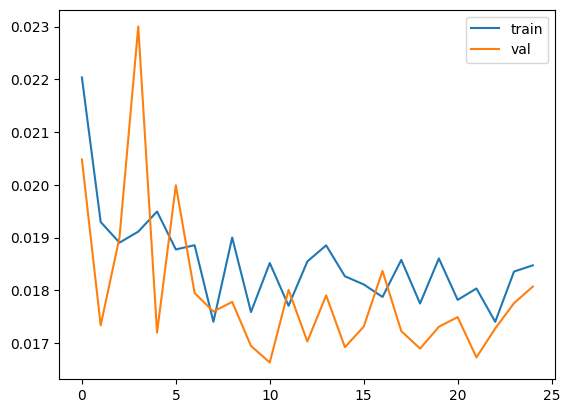

In [142]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

In [143]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

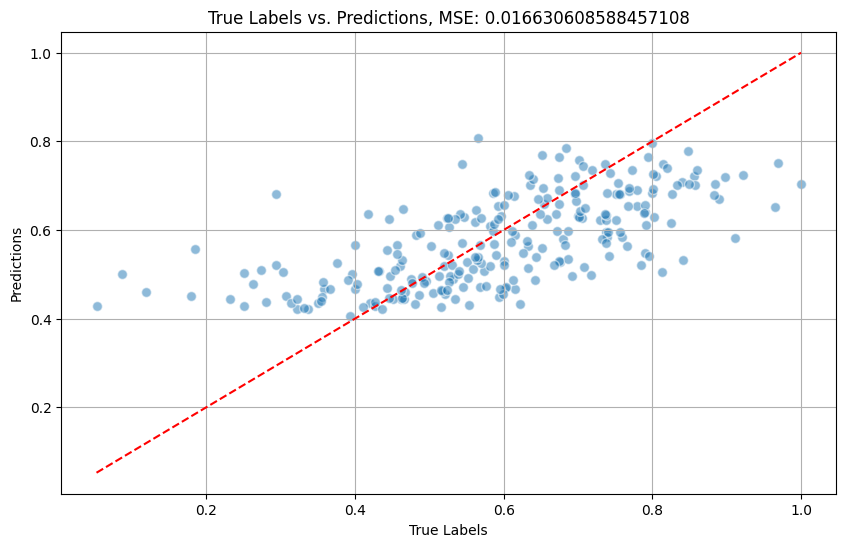

In [144]:
import matplotlib.pyplot as plt

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.show()


#### bigearthnet convnext v2 (freeze)

In [145]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error

In [146]:
# Get model
from reben_publication.BigEarthNetv2_0_ImageClassifier import BigEarthNetv2_0_ImageClassifier

model_reg = BigEarthNetv2_0_ImageClassifier.from_pretrained("BIFOLD-BigEarthNetv2-0/convnextv2_base-s2-v0.1.1")
# full layer at model_reg.model.vision_encoder.head.fc

# Freeze all weights
for param in model_reg.parameters():
    param.requires_grad = False
    
# Modify the model for regression by replacing head. new modules have requires_grad=True by default
num_features = model_reg.model.vision_encoder.head.fc.in_features  # Get the number of input features to the final layer

# Replace head
model_reg.model.vision_encoder.head.fc = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()\
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.model.vision_encoder.head.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/configilm/ConfigILM.py:134: UserWarning: Keyword 'img_size' unknown. Trying to ignore and restart creation.
  warnings.warn(f"Keyword '{failed_kw}' unknown. Trying to ignore and restart creation.")


In [147]:
class AddChannels(torch.nn.Module):
    def __init__(self, n_channels=10):
        super(AddChannels, self).__init__()
        self.n_channels = n_channels

    def forward(self, img):
        # Ensure the image is in tensor format
        if isinstance(img, Image.Image):
            img = transforms.ToTensor()(img)
        
        # Add channels
        current_channels, height, width = img.size()
        if current_channels != self.n_channels:
            extra_channels = torch.zeros((self.n_channels-current_channels, height, width),dtype=img.dtype)
            new_img = torch.cat([img, extra_channels], dim=0)
        else:
            new_img = img
        
        # Ensure label is returned as is or apply transformations if needed
        return new_img.float()

# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                            # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                           # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [148]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth Index - Scaled':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target.drop(columns='DHSCLUST', inplace=True)
df_target = df_target.astype({'target':'float32'})

In [149]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [150]:
# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [151]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 1m 31s


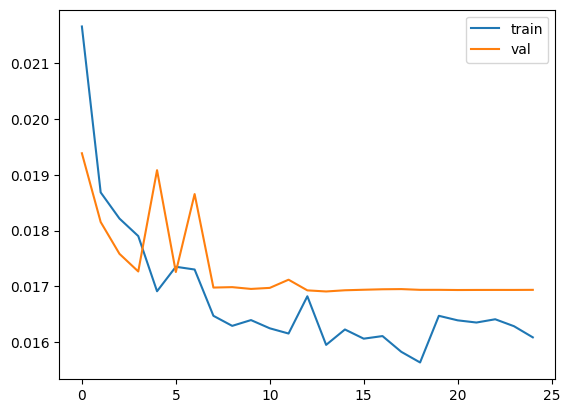

In [152]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

In [153]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

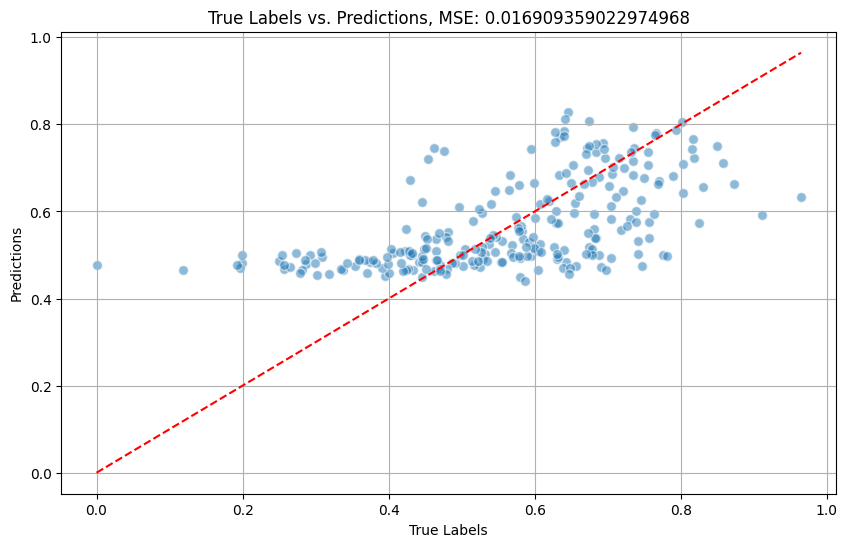

In [154]:
import matplotlib.pyplot as plt

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.show()

#### bigearthnet vitbase (freeze)

In [155]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error

In [156]:
# Get model
from reben_publication.BigEarthNetv2_0_ImageClassifier import BigEarthNetv2_0_ImageClassifier

model_reg = BigEarthNetv2_0_ImageClassifier.from_pretrained("BIFOLD-BigEarthNetv2-0/vit_base_patch8_224-s2-v0.1.1")
# full layer at model_reg.model.vision_encoder.head

# Freeze all weights
for param in model_reg.parameters():
    param.requires_grad = False
    
# Modify the model for regression by replacing head. new modules have requires_grad=True by default
num_features = model_reg.model.vision_encoder.head.in_features  # Get the number of input features to the final layer

# Just one simple layer
model_reg.model.vision_encoder.head = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()\
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.model.vision_encoder.head.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [157]:
class AddChannels(torch.nn.Module):
    def __init__(self, n_channels=10):
        super(AddChannels, self).__init__()
        self.n_channels = n_channels

    def forward(self, img):
        # Ensure the image is in tensor format
        if isinstance(img, Image.Image):
            img = transforms.ToTensor()(img)
        
        # Add channels
        current_channels, height, width = img.size()
        if current_channels != self.n_channels:
            extra_channels = torch.zeros((self.n_channels-current_channels, height, width),dtype=img.dtype)
            new_img = torch.cat([img, extra_channels], dim=0)
        else:
            new_img = img
        
        # Ensure label is returned as is or apply transformations if needed
        return new_img.float()

# transform
train_transform = transforms.Compose([
    transforms.Resize((120, 120)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                            # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

val_transform = transforms.Compose([
    transforms.Resize((120, 120)),                        # Resize to 224x224
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                           # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [158]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth Index - Scaled':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target.drop(columns='DHSCLUST', inplace=True)
df_target = df_target.astype({'target':'float32'})

In [159]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [160]:
# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [161]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 1m 16s


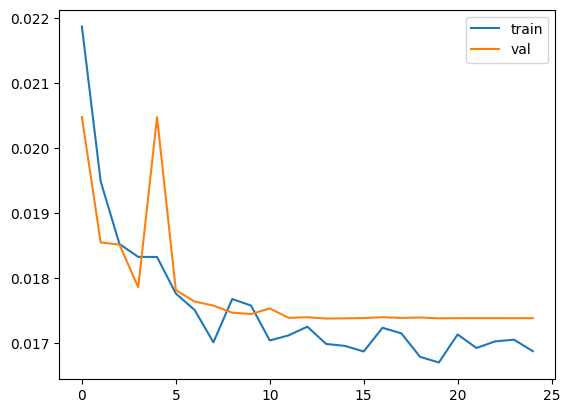

In [162]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

In [163]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

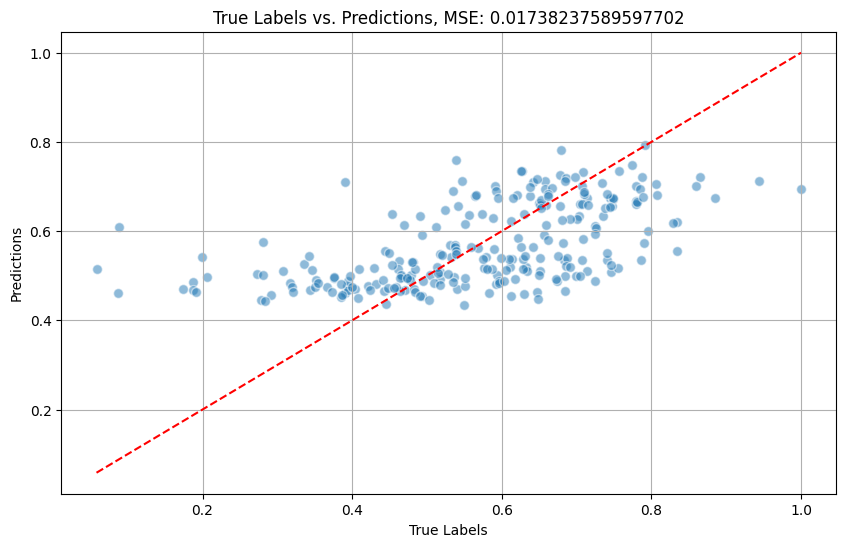

In [164]:
import matplotlib.pyplot as plt

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.show()


#### bigearthnet resnet101 (no freeze)

In [165]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error

In [166]:
# Get model
from reben_publication.BigEarthNetv2_0_ImageClassifier import BigEarthNetv2_0_ImageClassifier

model_reg = BigEarthNetv2_0_ImageClassifier.from_pretrained("BIFOLD-BigEarthNetv2-0/resnet101-s2-v0.1.1")
# full layer at model_reg.model.vision_encoder.fc

# # Freeze all weights
# for param in model_reg.parameters():
#     param.requires_grad = False
    
# Modify the model for regression by replacing head. new modules have requires_grad=True by default
num_features = model_reg.model.vision_encoder.fc.in_features  # Get the number of input features to the final layer

# Just one simple layer
model_reg.model.vision_encoder.fc = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()\
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.model.vision_encoder.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/configilm/ConfigILM.py:134: UserWarning: Keyword 'img_size' unknown. Trying to ignore and restart creation.
  warnings.warn(f"Keyword '{failed_kw}' unknown. Trying to ignore and restart creation.")


In [167]:
class AddChannels(torch.nn.Module):
    def __init__(self, n_channels=10):
        super(AddChannels, self).__init__()
        self.n_channels = n_channels

    def forward(self, img):
        # Ensure the image is in tensor format
        if isinstance(img, Image.Image):
            img = transforms.ToTensor()(img)
        
        # Add channels
        current_channels, height, width = img.size()
        if current_channels != self.n_channels:
            extra_channels = torch.zeros((self.n_channels-current_channels, height, width),dtype=img.dtype)
            new_img = torch.cat([img, extra_channels], dim=0)
        else:
            new_img = img
        
        # Ensure label is returned as is or apply transformations if needed
        return new_img.float()

In [168]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                            # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                           # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [169]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth Index - Scaled':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target.drop(columns='DHSCLUST', inplace=True)
df_target = df_target.astype({'target':'float32'})

In [170]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [171]:
# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
}

In [172]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 1m 39s


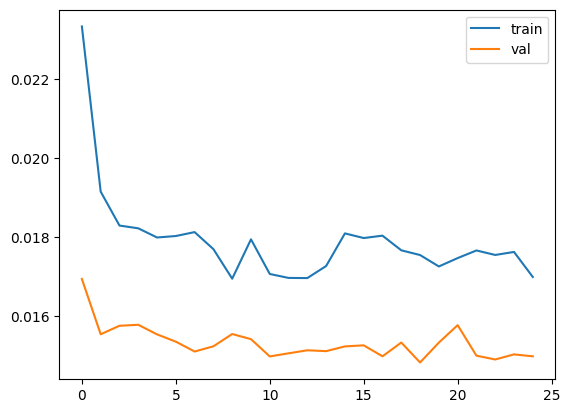

In [173]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

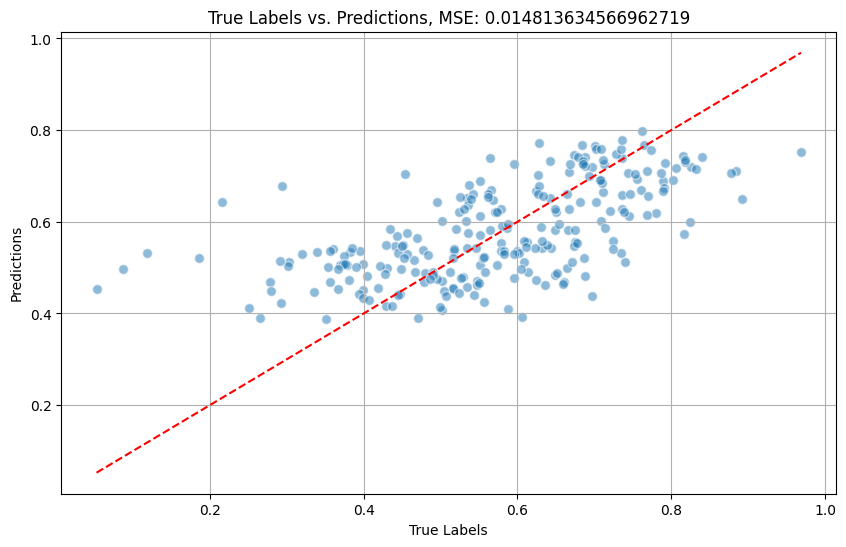

In [174]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

import matplotlib.pyplot as plt

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.show()

In [175]:
import torch
import torch.nn as nn
from torchvision import models


# Calculate the number of trainable parameters
trainable_params = sum(p.numel() for p in model_reg.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {trainable_params}")


Number of trainable parameters: 42524161


#### bigearthnet vit base (no freeze)

In [176]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error

In [177]:
# Get model
from reben_publication.BigEarthNetv2_0_ImageClassifier import BigEarthNetv2_0_ImageClassifier

model_reg = BigEarthNetv2_0_ImageClassifier.from_pretrained("BIFOLD-BigEarthNetv2-0/vit_base_patch8_224-s2-v0.1.1")
# full layer at model_reg.model.vision_encoder.head

# # Freeze all weights
# for param in model_reg.parameters():
#     param.requires_grad = False
    
# Modify the model for regression by replacing head. new modules have requires_grad=True by default
num_features = model_reg.model.vision_encoder.head.in_features  # Get the number of input features to the final layer

# Just one simple layer
model_reg.model.vision_encoder.head = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()\
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.model.vision_encoder.head.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [178]:
class AddChannels(torch.nn.Module):
    def __init__(self, n_channels=10):
        super(AddChannels, self).__init__()
        self.n_channels = n_channels

    def forward(self, img):
        # Ensure the image is in tensor format
        if isinstance(img, Image.Image):
            img = transforms.ToTensor()(img)
        
        # Add channels
        current_channels, height, width = img.size()
        if current_channels != self.n_channels:
            extra_channels = torch.zeros((self.n_channels-current_channels, height, width),dtype=img.dtype)
            new_img = torch.cat([img, extra_channels], dim=0)
        else:
            new_img = img
        
        # Ensure label is returned as is or apply transformations if needed
        return new_img.float()

# transform
train_transform = transforms.Compose([
    transforms.Resize((120, 120)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                            # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

val_transform = transforms.Compose([
    transforms.Resize((120, 120)),                        # Resize to 224x224
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                           # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [179]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth Index - Scaled':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target.drop(columns='DHSCLUST', inplace=True)
df_target = df_target.astype({'target':'float32'})

In [180]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [181]:
# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [182]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 3m 6s


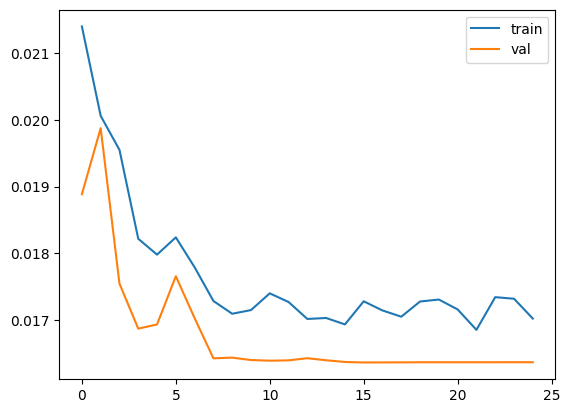

In [183]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

In [184]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

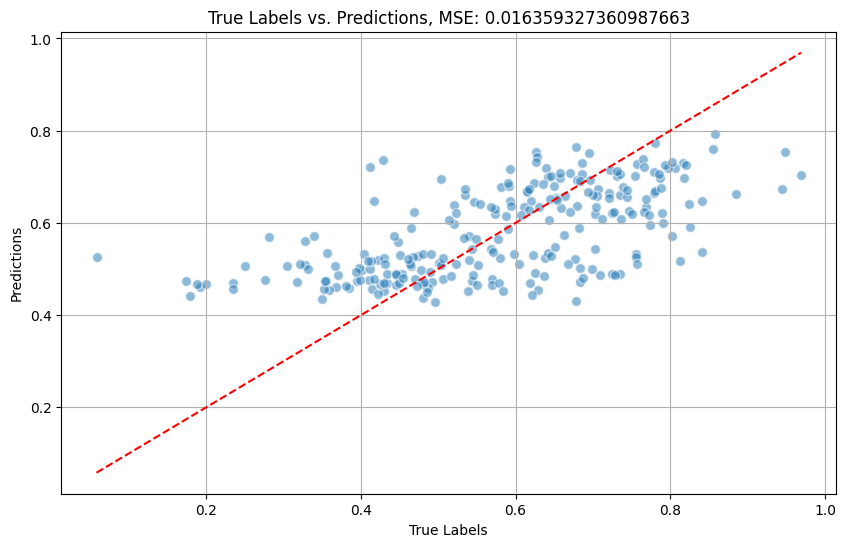

In [185]:
import matplotlib.pyplot as plt

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.show()


#### direct resnet101 (freeze)

In [186]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error

In [187]:
model_reg = models.resnet101(pretrained=True)

# Freeze all weights
for param in model_reg.parameters():
    param.requires_grad = False

# Modify the model for regression by replacing head. new modules have requires_grad=True by default
num_features = model_reg.fc.in_features  # Get the number of input features to the final layer

# Just one simple layer
model_reg.fc = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()\
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Calculate the number of trainable parameters
trainable_params = sum(p.numel() for p in model_reg.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {trainable_params}")

/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of trainable parameters: 2049


In [188]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.ToTensor(),                                # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225])
])

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth Index - Scaled':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target.drop(columns='DHSCLUST', inplace=True)
df_target = df_target.astype({'target':'float32'})

In [189]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [190]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 0m 47s


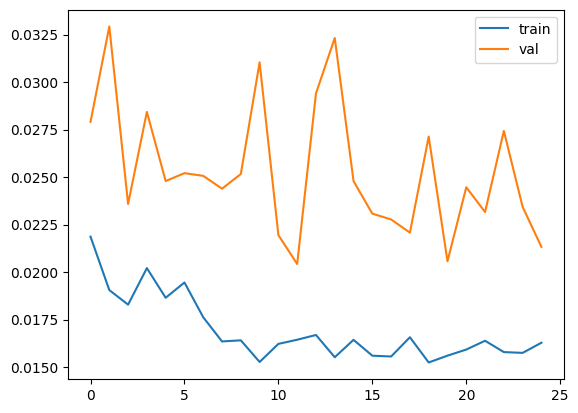

In [191]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

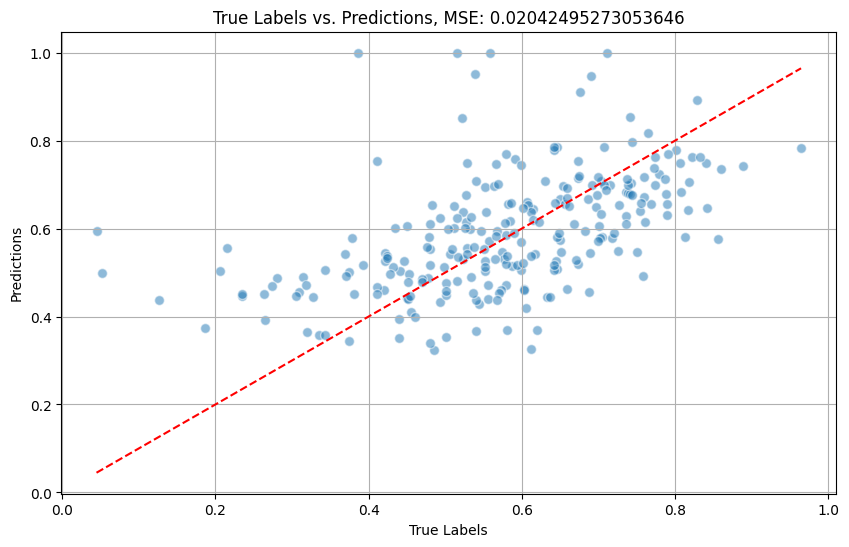

In [192]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

#### direct convnext v2 (freeze)

In [193]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoImageProcessor, ConvNextV2Model
import timm

from sklearn.metrics import mean_squared_error

In [194]:
class ConvNeXtForRegression(nn.Module):
    def __init__(self, base_model):
        super(ConvNeXtForRegression, self).__init__()
        self.backbone = base_model
        # Add a regression head
        self.fc = nn.Sequential(
            nn.Linear(base_model.num_features, 1),
            nn.Sigmoid()
        )
        # Freeze the weights of the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return outputs

# Create base model
model_base = timm.create_model(
    'convnextv2_base.fcmae',
    pretrained=True,
    num_classes=0,
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = ConvNeXtForRegression(model_base)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [195]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

val_transform = model_transforms

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [196]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth Index - Scaled':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target.drop(columns='DHSCLUST', inplace=True)
df_target = df_target.astype({'target':'float32'})

In [197]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [198]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 1m 21s


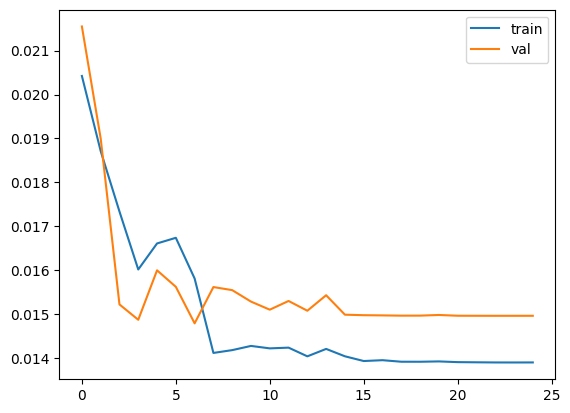

In [199]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

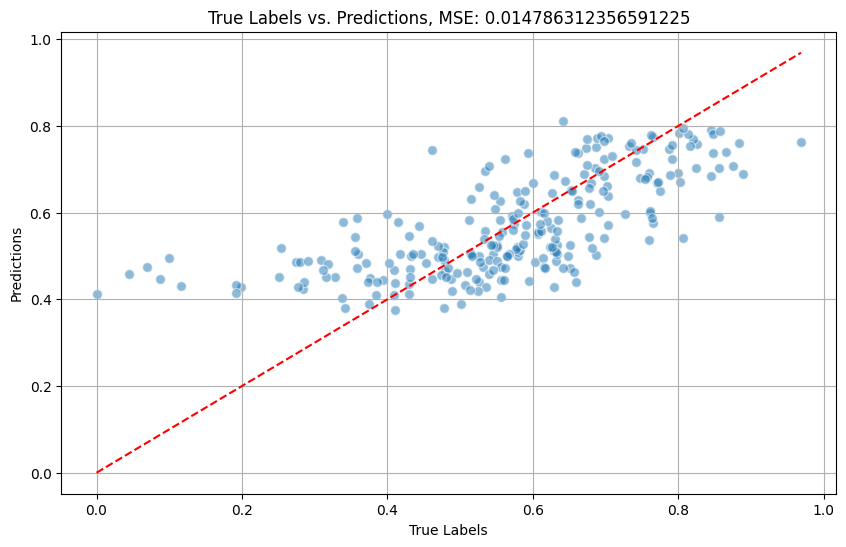

In [200]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

#### direct vit base (freeze)

In [8]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoImageProcessor, ConvNextV2Model
import timm

from sklearn.metrics import mean_squared_error

In [9]:
class ConvNeXtForRegression(nn.Module):
    def __init__(self, base_model):
        super(ConvNeXtForRegression, self).__init__()
        self.backbone = base_model
        # Add a regression head
        self.fc = nn.Sequential(
            nn.Linear(base_model.num_features, 1),
            nn.Sigmoid()
        )

        # Freeze the weights of the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return outputs

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = ConvNeXtForRegression(model_base)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [10]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

val_transform = model_transforms

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [11]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth Index - Scaled':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target.drop(columns='DHSCLUST', inplace=True)
df_target = df_target.astype({'target':'float32'})

In [12]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [13]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

In [14]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=1,plot_curves=True)

Epoch 0/24
----------
train Loss: 0.0401
val Loss: 0.0224

Epoch 1/24
----------
train Loss: 0.0245
val Loss: 0.0202

Epoch 2/24
----------


KeyboardInterrupt: 

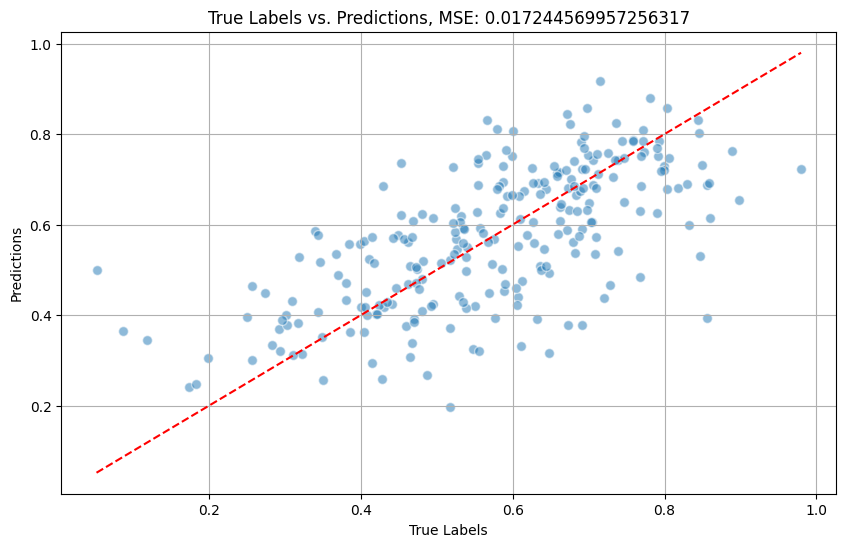

In [208]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

#### direct vit base (no freeze)

In [209]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoImageProcessor, ConvNextV2Model
import timm

from sklearn.metrics import mean_squared_error

In [210]:
class ConvNeXtForRegression(nn.Module):
    def __init__(self, base_model):
        super(ConvNeXtForRegression, self).__init__()
        self.backbone = base_model
        # Add a regression head
        self.fc = nn.Sequential(
            nn.Linear(base_model.num_features, 1),
            nn.Sigmoid()
        )
        # # Freeze the weights of the backbone
        # for param in self.backbone.parameters():
        #     param.requires_grad = False
            
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return outputs

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = ConvNeXtForRegression(model_base)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [211]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

val_transform = model_transforms

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [212]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth Index - Scaled':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target.drop(columns='DHSCLUST', inplace=True)
df_target = df_target.astype({'target':'float32'})

In [213]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [214]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 2m 45s


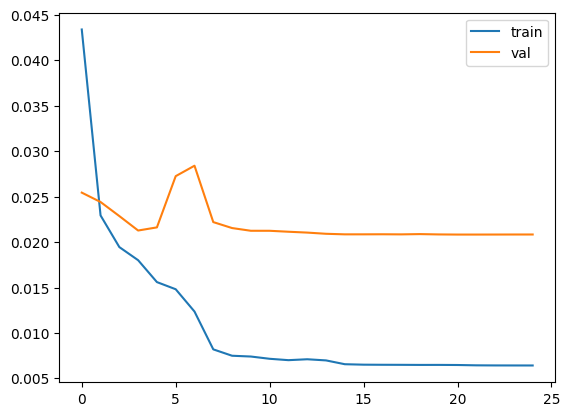

In [215]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

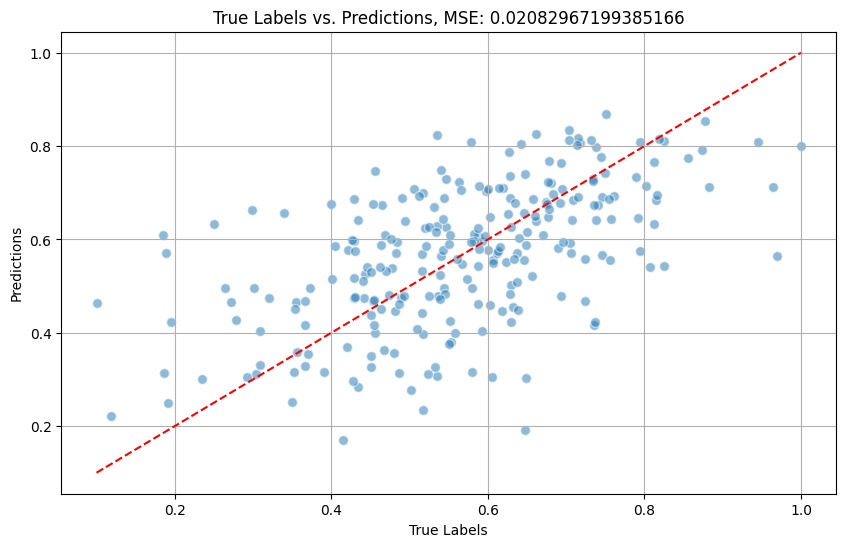

In [216]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

### Train model on nightlight

#### Check out label distribution

In [79]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'X.csv'))\
    .rename(columns={'avg_rad_min':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target = df_target[['filename','target']]
df_target = df_target.astype({'target':'float32'})

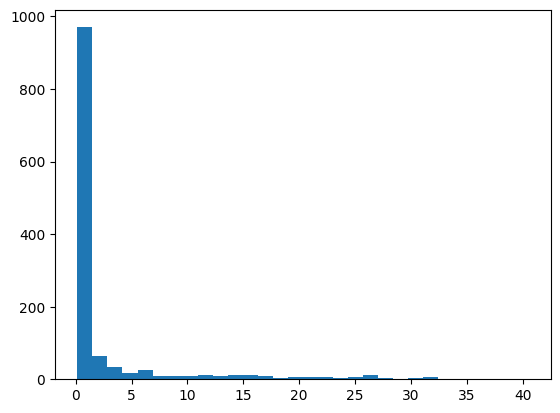

In [80]:
plt.hist(df_target.target,bins=30);

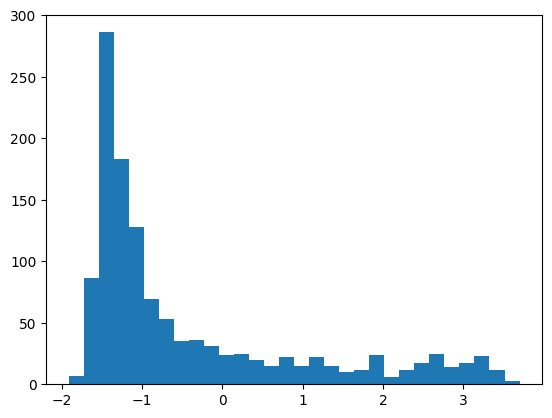

In [81]:
plt.hist(np.log(df_target.target),bins=30);

In [90]:
mmscaler = MinMaxScaler()
mm_scaled_target = mmscaler.fit_transform(np.log(df_target[['target']]))

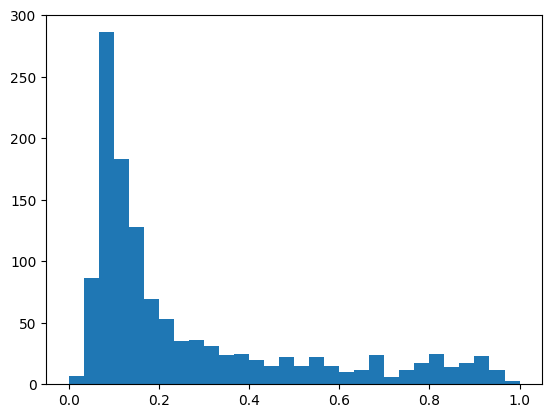

In [91]:
plt.hist(mm_scaled_target,bins=30);

In [89]:
mm_scaled_target.max()
# plt.hist(np.log(mm_scaled_target),bins=30);


/tmp/ipykernel_85333/2933082444.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(0)


-inf

#### bigearthnet resnet101 (freeze)

In [355]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error

In [356]:
# Get model
from reben_publication.BigEarthNetv2_0_ImageClassifier import BigEarthNetv2_0_ImageClassifier

model_reg = BigEarthNetv2_0_ImageClassifier.from_pretrained("BIFOLD-BigEarthNetv2-0/resnet101-s2-v0.1.1")
# full layer at model_reg.model.vision_encoder.fc

# Freeze all weights
for param in model_reg.parameters():
    param.requires_grad = False
    
# Modify the model for regression by replacing head. new modules have requires_grad=True by default
num_features = model_reg.model.vision_encoder.fc.in_features  # Get the number of input features to the final layer

# Replace head
model_reg.model.vision_encoder.fc = nn.Linear(num_features, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.model.vision_encoder.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/configilm/ConfigILM.py:134: UserWarning: Keyword 'img_size' unknown. Trying to ignore and restart creation.
  warnings.warn(f"Keyword '{failed_kw}' unknown. Trying to ignore and restart creation.")


In [357]:
import torch
import torch.nn as nn
from torchvision import models

# Calculate the number of trainable parameters
trainable_params = sum(p.numel() for p in model_reg.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {trainable_params}")


Number of trainable parameters: 2049


In [358]:
class AddChannels(torch.nn.Module):
    def __init__(self, n_channels=10):
        super(AddChannels, self).__init__()
        self.n_channels = n_channels

    def forward(self, img):
        # Ensure the image is in tensor format
        if isinstance(img, Image.Image):
            img = transforms.ToTensor()(img)
        
        # Add channels
        current_channels, height, width = img.size()
        if current_channels != self.n_channels:
            extra_channels = torch.zeros((self.n_channels-current_channels, height, width),dtype=img.dtype)
            new_img = torch.cat([img, extra_channels], dim=0)
        else:
            new_img = img
        
        # Ensure label is returned as is or apply transformations if needed
        return new_img.float()

# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                            # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                           # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [359]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'X.csv'))\
    .rename(columns={'avg_rad_min':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target = df_target[['filename','target']]
df_target['target'] = np.log(df_target['target'])
df_target = df_target.astype({'target':'float32'})

In [360]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [361]:
# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [362]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 0m 59s


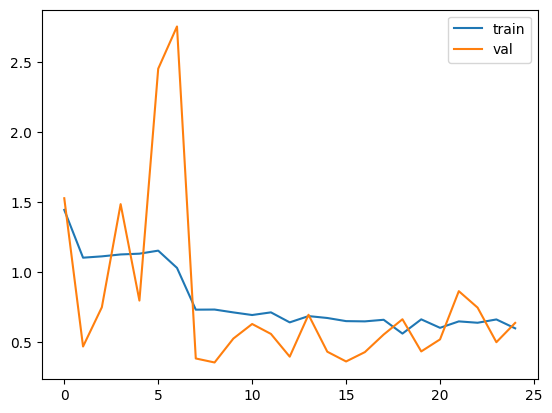

In [363]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

In [364]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

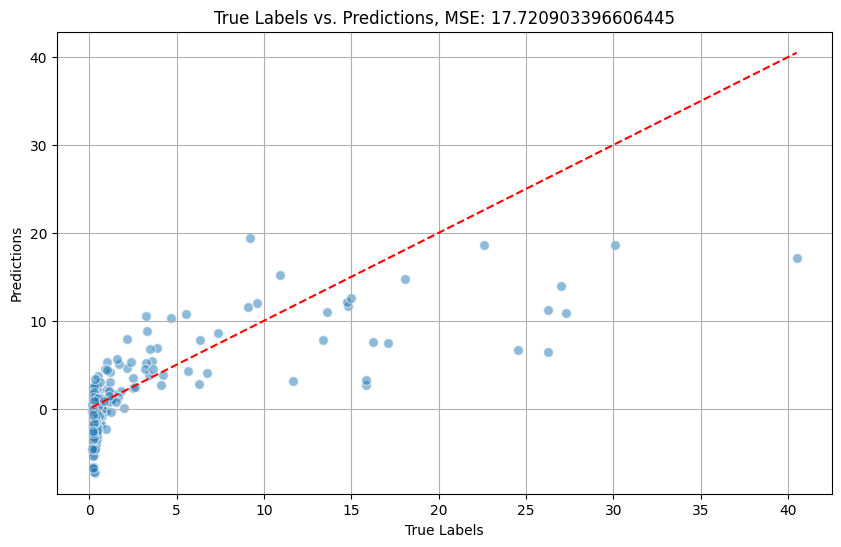

In [354]:
import matplotlib.pyplot as plt

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.show()


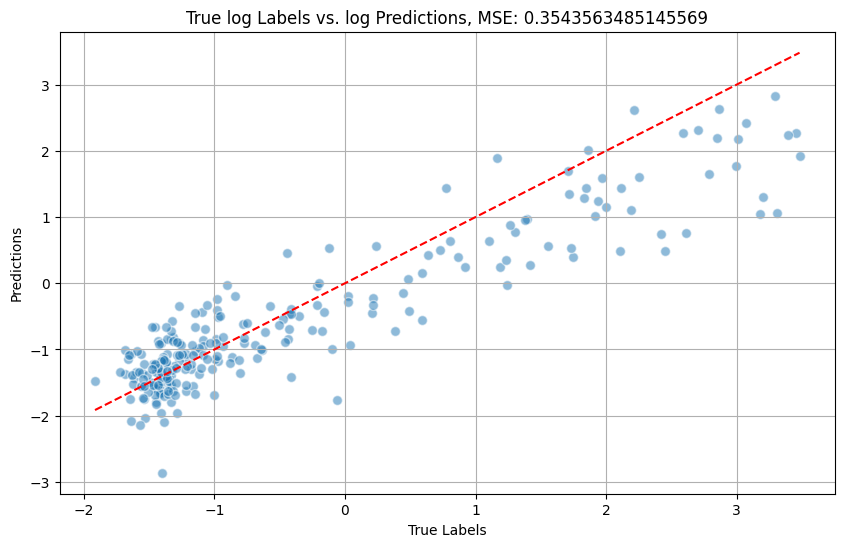

In [365]:
import matplotlib.pyplot as plt

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True log Labels vs. log Predictions, MSE: {mse}')
plt.grid(True)
plt.show()


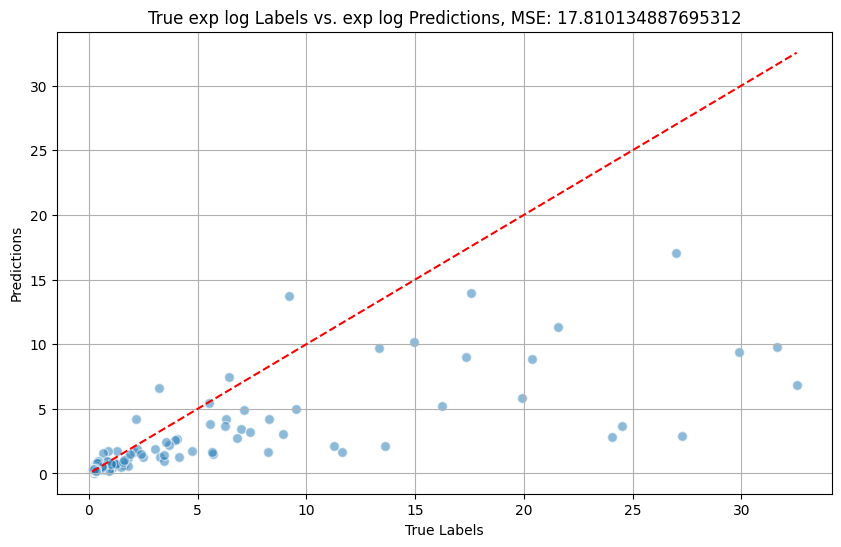

In [366]:
import matplotlib.pyplot as plt

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(np.exp(all_labels), np.exp(all_outputs), alpha=0.5, edgecolors='w', s=50)
plt.plot([min(np.exp(all_labels)), max(np.exp(all_labels))], [min(np.exp(all_labels)), max(np.exp(all_labels))], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(np.exp(all_labels), np.exp(all_outputs))

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True exp log Labels vs. exp log Predictions, MSE: {mse}')
plt.grid(True)
plt.show()


#### bigearthnet convnext v2 (freeze)

In [228]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error

In [229]:
# Get model
from reben_publication.BigEarthNetv2_0_ImageClassifier import BigEarthNetv2_0_ImageClassifier

model_reg = BigEarthNetv2_0_ImageClassifier.from_pretrained("BIFOLD-BigEarthNetv2-0/convnextv2_base-s2-v0.1.1")
# full layer at model_reg.model.vision_encoder.head.fc

# Freeze all weights
for param in model_reg.parameters():
    param.requires_grad = False
    
# Modify the model for regression by replacing head. new modules have requires_grad=True by default
num_features = model_reg.model.vision_encoder.head.fc.in_features  # Get the number of input features to the final layer

# Replace head
model_reg.model.vision_encoder.head.fc = nn.Linear(num_features, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.model.vision_encoder.head.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/configilm/ConfigILM.py:134: UserWarning: Keyword 'img_size' unknown. Trying to ignore and restart creation.
  warnings.warn(f"Keyword '{failed_kw}' unknown. Trying to ignore and restart creation.")


In [230]:
class AddChannels(torch.nn.Module):
    def __init__(self, n_channels=10):
        super(AddChannels, self).__init__()
        self.n_channels = n_channels

    def forward(self, img):
        # Ensure the image is in tensor format
        if isinstance(img, Image.Image):
            img = transforms.ToTensor()(img)
        
        # Add channels
        current_channels, height, width = img.size()
        if current_channels != self.n_channels:
            extra_channels = torch.zeros((self.n_channels-current_channels, height, width),dtype=img.dtype)
            new_img = torch.cat([img, extra_channels], dim=0)
        else:
            new_img = img
        
        # Ensure label is returned as is or apply transformations if needed
        return new_img.float()

# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                            # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                           # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [231]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'X.csv'))\
    .rename(columns={'avg_rad_min':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target = df_target[['filename','target']]
df_target = df_target.astype({'target':'float32'})

In [232]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [233]:
# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [234]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 1m 30s


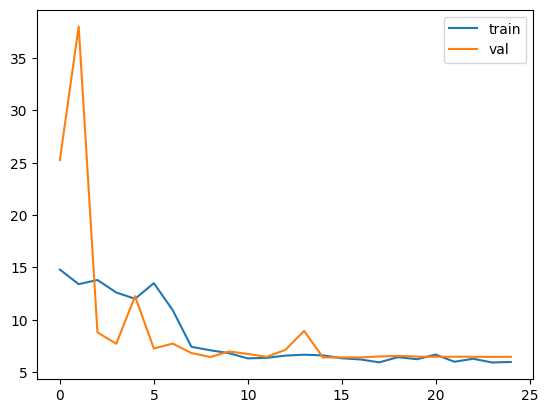

In [235]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

In [236]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

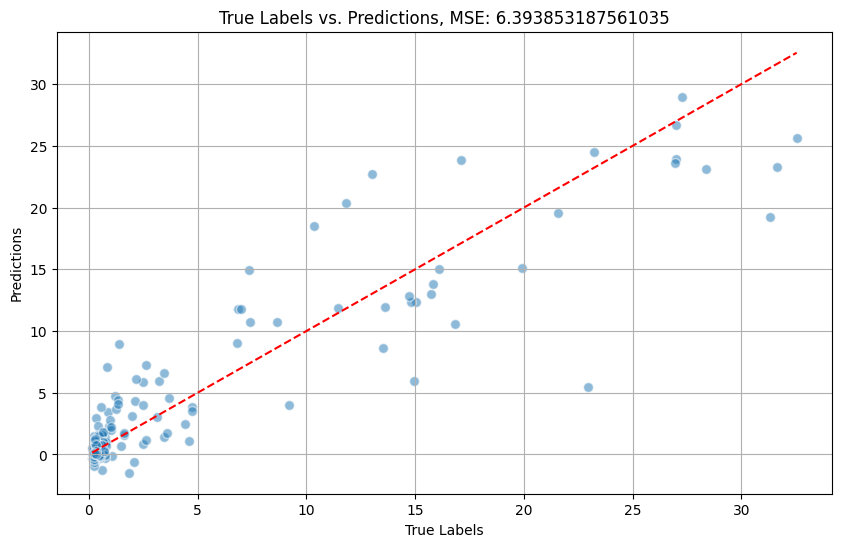

In [237]:
import matplotlib.pyplot as plt

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.show()

#### bigearthnet vitbase (freeze)

In [238]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error

In [239]:
# Get model
from reben_publication.BigEarthNetv2_0_ImageClassifier import BigEarthNetv2_0_ImageClassifier

model_reg = BigEarthNetv2_0_ImageClassifier.from_pretrained("BIFOLD-BigEarthNetv2-0/vit_base_patch8_224-s2-v0.1.1")
# full layer at model_reg.model.vision_encoder.head

# Freeze all weights
for param in model_reg.parameters():
    param.requires_grad = False
    
# Modify the model for regression by replacing head. new modules have requires_grad=True by default
num_features = model_reg.model.vision_encoder.head.in_features  # Get the number of input features to the final layer

# Just one simple layer
model_reg.model.vision_encoder.head = torch.nn.Linear(num_features, 1)  # Replace with a new Linear layer for regression (output 1 value)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.model.vision_encoder.head.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [240]:
class AddChannels(torch.nn.Module):
    def __init__(self, n_channels=10):
        super(AddChannels, self).__init__()
        self.n_channels = n_channels

    def forward(self, img):
        # Ensure the image is in tensor format
        if isinstance(img, Image.Image):
            img = transforms.ToTensor()(img)
        
        # Add channels
        current_channels, height, width = img.size()
        if current_channels != self.n_channels:
            extra_channels = torch.zeros((self.n_channels-current_channels, height, width),dtype=img.dtype)
            new_img = torch.cat([img, extra_channels], dim=0)
        else:
            new_img = img
        
        # Ensure label is returned as is or apply transformations if needed
        return new_img.float()

# transform
train_transform = transforms.Compose([
    transforms.Resize((120, 120)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                            # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

val_transform = transforms.Compose([
    transforms.Resize((120, 120)),                        # Resize to 224x224
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                           # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [241]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'X.csv'))\
    .rename(columns={'avg_rad_min':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target = df_target[['filename','target']]
df_target = df_target.astype({'target':'float32'})

In [242]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [243]:
# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [244]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 1m 14s


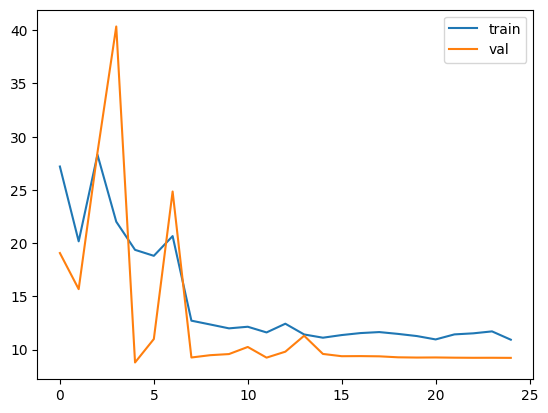

In [245]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

In [246]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

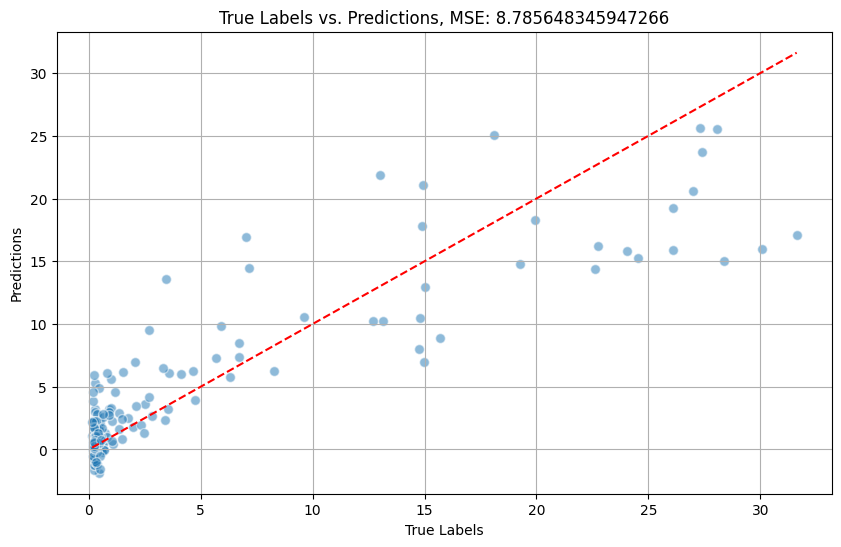

In [247]:
import matplotlib.pyplot as plt

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.show()


#### bigearthnet resnet101 (no freeze)

In [248]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error

In [249]:
# Get model
from reben_publication.BigEarthNetv2_0_ImageClassifier import BigEarthNetv2_0_ImageClassifier

model_reg = BigEarthNetv2_0_ImageClassifier.from_pretrained("BIFOLD-BigEarthNetv2-0/resnet101-s2-v0.1.1")
# full layer at model_reg.model.vision_encoder.fc

# # Freeze all weights
# for param in model_reg.parameters():
#     param.requires_grad = False
    
# Modify the model for regression by replacing head. new modules have requires_grad=True by default
num_features = model_reg.model.vision_encoder.fc.in_features  # Get the number of input features to the final layer

# Just one simple layer
model_reg.model.vision_encoder.fc = torch.nn.Linear(num_features, 1)  # Replace with a new Linear layer for regression (output 1 value)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.model.vision_encoder.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/configilm/ConfigILM.py:134: UserWarning: Keyword 'img_size' unknown. Trying to ignore and restart creation.
  warnings.warn(f"Keyword '{failed_kw}' unknown. Trying to ignore and restart creation.")


In [250]:
class AddChannels(torch.nn.Module):
    def __init__(self, n_channels=10):
        super(AddChannels, self).__init__()
        self.n_channels = n_channels

    def forward(self, img):
        # Ensure the image is in tensor format
        if isinstance(img, Image.Image):
            img = transforms.ToTensor()(img)
        
        # Add channels
        current_channels, height, width = img.size()
        if current_channels != self.n_channels:
            extra_channels = torch.zeros((self.n_channels-current_channels, height, width),dtype=img.dtype)
            new_img = torch.cat([img, extra_channels], dim=0)
        else:
            new_img = img
        
        # Ensure label is returned as is or apply transformations if needed
        return new_img.float()

# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                            # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                           # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [251]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'X.csv'))\
    .rename(columns={'avg_rad_min':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target = df_target[['filename','target']]
df_target = df_target.astype({'target':'float32'})

In [252]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
}

In [253]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 1m 38s


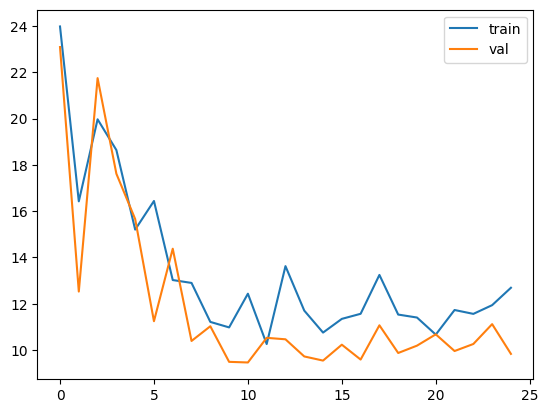

In [254]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

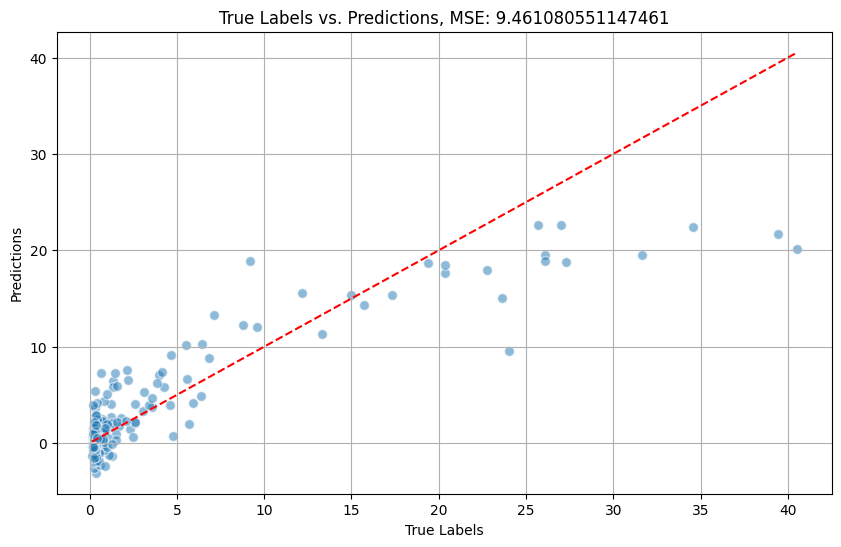

In [255]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

import matplotlib.pyplot as plt

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.show()

In [256]:
import torch
import torch.nn as nn
from torchvision import models


# Calculate the number of trainable parameters
trainable_params = sum(p.numel() for p in model_reg.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {trainable_params}")


Number of trainable parameters: 42524161


#### bigearthnet vit base (no freeze)

In [257]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error

In [258]:
# Get model
from reben_publication.BigEarthNetv2_0_ImageClassifier import BigEarthNetv2_0_ImageClassifier

model_reg = BigEarthNetv2_0_ImageClassifier.from_pretrained("BIFOLD-BigEarthNetv2-0/vit_base_patch8_224-s2-v0.1.1")
# full layer at model_reg.model.vision_encoder.head

# # Freeze all weights
# for param in model_reg.parameters():
#     param.requires_grad = False
    
# Modify the model for regression by replacing head. new modules have requires_grad=True by default
num_features = model_reg.model.vision_encoder.head.in_features  # Get the number of input features to the final layer

# Just one simple layer
model_reg.model.vision_encoder.head = torch.nn.Linear(num_features, 1)  # Replace with a new Linear layer for regression (output 1 value)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.model.vision_encoder.head.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [259]:
class AddChannels(torch.nn.Module):
    def __init__(self, n_channels=10):
        super(AddChannels, self).__init__()
        self.n_channels = n_channels

    def forward(self, img):
        # Ensure the image is in tensor format
        if isinstance(img, Image.Image):
            img = transforms.ToTensor()(img)
        
        # Add channels
        current_channels, height, width = img.size()
        if current_channels != self.n_channels:
            extra_channels = torch.zeros((self.n_channels-current_channels, height, width),dtype=img.dtype)
            new_img = torch.cat([img, extra_channels], dim=0)
        else:
            new_img = img
        
        # Ensure label is returned as is or apply transformations if needed
        return new_img.float()

# transform
train_transform = transforms.Compose([
    transforms.Resize((120, 120)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                            # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

val_transform = transforms.Compose([
    transforms.Resize((120, 120)),                        # Resize to 224x224
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                           # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [260]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'X.csv'))\
    .rename(columns={'avg_rad_min':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target = df_target[['filename','target']]
df_target = df_target.astype({'target':'float32'})

In [261]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [262]:
# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [263]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 3m 8s


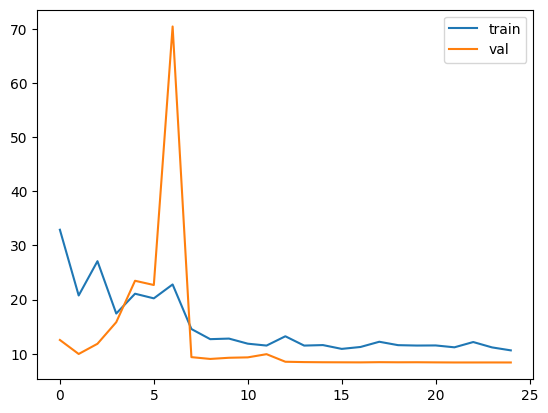

In [264]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

In [265]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

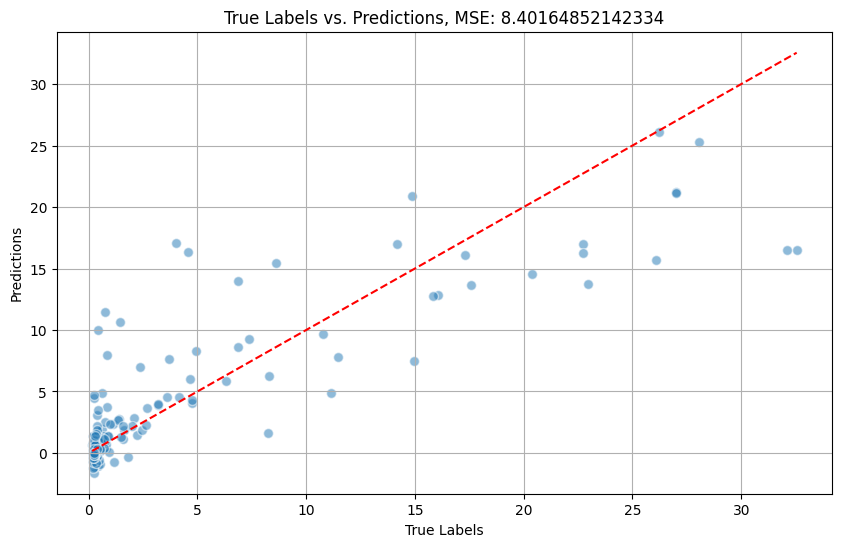

In [266]:
import matplotlib.pyplot as plt

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.show()


#### direct resnet101 (freeze)

In [1]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error

In [2]:
model_reg = models.resnet101(pretrained=True)

# Freeze all weights
for param in model_reg.parameters():
    param.requires_grad = False

# Modify the model for regression by replacing head. new modules have requires_grad=True by default
num_features = model_reg.fc.in_features  # Get the number of input features to the final layer

# Just one simple layer
model_reg.fc = nn.Linear(num_features, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Calculate the number of trainable parameters
trainable_params = sum(p.numel() for p in model_reg.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {trainable_params}")

/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of trainable parameters: 2049


In [338]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.ToTensor(),                                # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225])
])

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [339]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'X.csv'))\
    .rename(columns={'avg_rad_min':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target = df_target[['filename','target']]
df_target = df_target.astype({'target':'float32'})

In [340]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [341]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 0m 47s


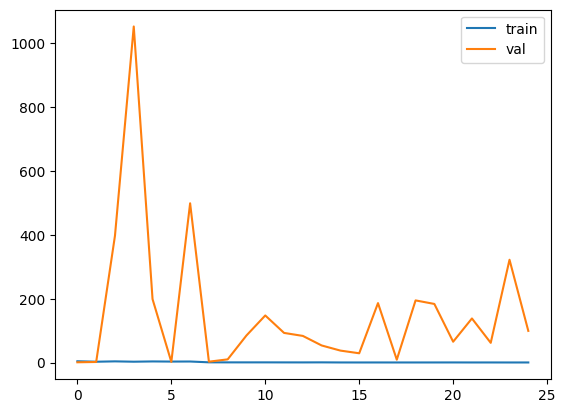

In [342]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

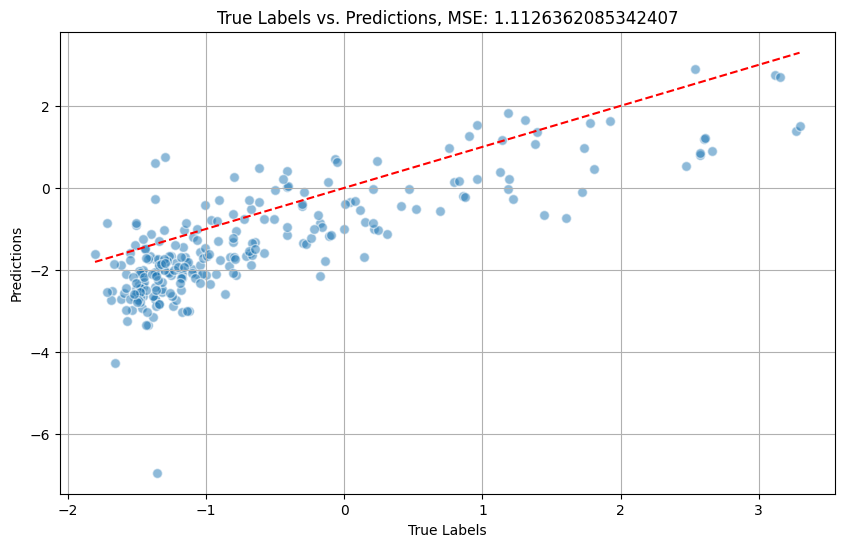

In [343]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

#### direct convnext v2 (freeze)

In [275]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoImageProcessor, ConvNextV2Model
import timm

from sklearn.metrics import mean_squared_error

In [276]:
class ConvNeXtForRegression(nn.Module):
    def __init__(self, base_model):
        super(ConvNeXtForRegression, self).__init__()
        self.backbone = base_model
        # Add a regression head
        self.fc = nn.Linear(base_model.num_features, 1)
        # Freeze the weights of the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return outputs

# Create base model
model_base = timm.create_model(
    'convnextv2_base.fcmae',
    pretrained=True,
    num_classes=0,
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = ConvNeXtForRegression(model_base)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [277]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

val_transform = model_transforms

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [278]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'X.csv'))\
    .rename(columns={'avg_rad_min':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target = df_target[['filename','target']]
df_target = df_target.astype({'target':'float32'})

In [279]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [280]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 1m 22s


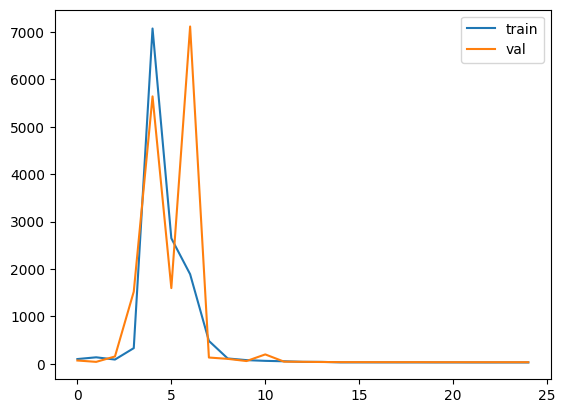

In [281]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

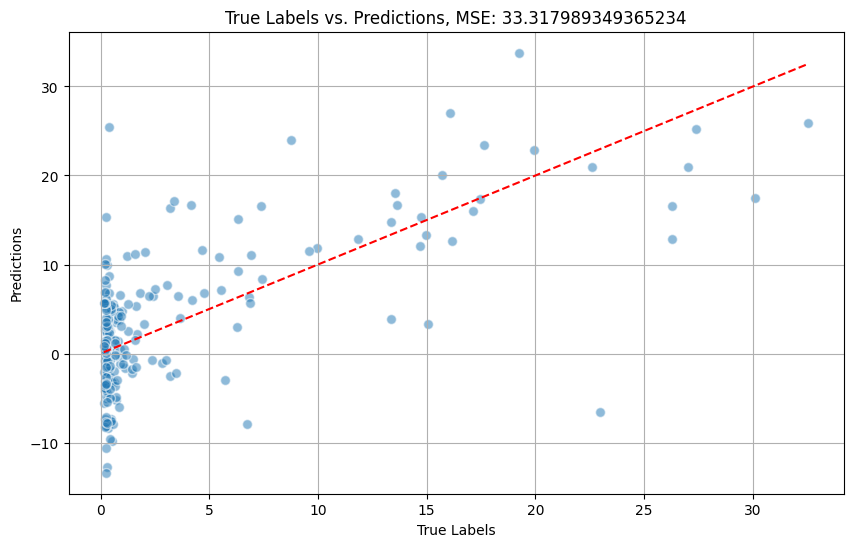

In [282]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

#### direct vit base (freeze)

In [1]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoImageProcessor, ConvNextV2Model
import timm

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [71]:
class ConvNeXtForRegression(nn.Module):
    def __init__(self, base_model):
        super(ConvNeXtForRegression, self).__init__()
        self.backbone = base_model
        # Add a regression head
        # self.fc = nn.Sequential(
        #     nn.Linear(base_model.num_features, 1),
        #     nn.Sigmoid()
        # )

        # self.fc = nn.Sequential(
        #     nn.Linear(base_model.num_features, 512),  # First layer
        #     nn.ReLU(),                                # Activation function
        #     nn.Dropout(0.3),                          # Dropout for regularization
        #     nn.Linear(512, 256),                      # Second layer
        #     nn.ReLU(),                                # Activation function
        #     nn.Dropout(0.3),                          # Dropout for regularization
        #     nn.Linear(256, 128),                      # Third layer
        #     nn.ReLU(),                                # Activation function
        #     nn.Linear(128, 1),                        # Output layer
        #     nn.Sigmoid()                              # Activation function for output
        # )



        self.fc = nn.Sequential(
            nn.Linear(base_model.num_features, 512),  # First layer
            nn.BatchNorm1d(512),                      # Batch normalization
            nn.ReLU(),                                # Activation function
            nn.Dropout(0.3),                          # Dropout for regularization
            
            nn.Linear(512, 256),                      # Second layer
            nn.BatchNorm1d(256),                      # Batch normalization
            nn.ReLU(),                                # Activation function
            nn.Dropout(0.3),                          # Dropout for regularization
            
            nn.Linear(256, 128),                      # Third layer
            nn.BatchNorm1d(128),                      # Batch normalization
            nn.ReLU(),                                # Activation function
            
            nn.Linear(128, 1),                        # Output layer
            # nn.Sigmoid()                              # Activation function for output
        )
        
        # Freeze the weights of the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return outputs

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = ConvNeXtForRegression(model_base)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [72]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

val_transform = model_transforms

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [73]:
# Load target information, log transform then min max scale
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'X.csv'))\
    .rename(columns={'avg_rad_min':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target = df_target[['filename','target']]
# mmscaler = MinMaxScaler()
# df_target['target'] = mmscaler.fit_transform(np.log(df_target[['target']])) 
df_target = df_target.astype({'target':'float32'})

In [74]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [75]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([num_epochs]), 'val':np.zeros([num_epochs])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Epoch 0/9
----------
train Loss: 26.0043
val Loss: 15.3280

Epoch 1/9
----------
train Loss: 19.3630
val Loss: 8.7711

Epoch 2/9
----------
train Loss: 18.0106
val Loss: 66.8453

Epoch 3/9
----------
train Loss: 15.4856
val Loss: 5.6160

Epoch 4/9
----------
train Loss: 12.4488
val Loss: 14.2933

Epoch 5/9
----------
train Loss: 11.9075
val Loss: 5.7819

Epoch 6/9
----------
train Loss: 10.6215
val Loss: 8.2058

Epoch 7/9
----------
train Loss: 11.7410
val Loss: 9.2673

Epoch 8/9
----------
train Loss: 12.5426
val Loss: 6.3625

Epoch 9/9
----------
train Loss: 10.5518
val Loss: 7.5619

Training complete in 0m 27s


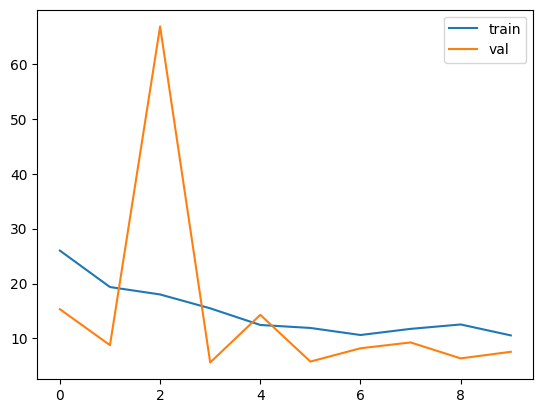

In [76]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10,verbose=1,plot_curves=True)

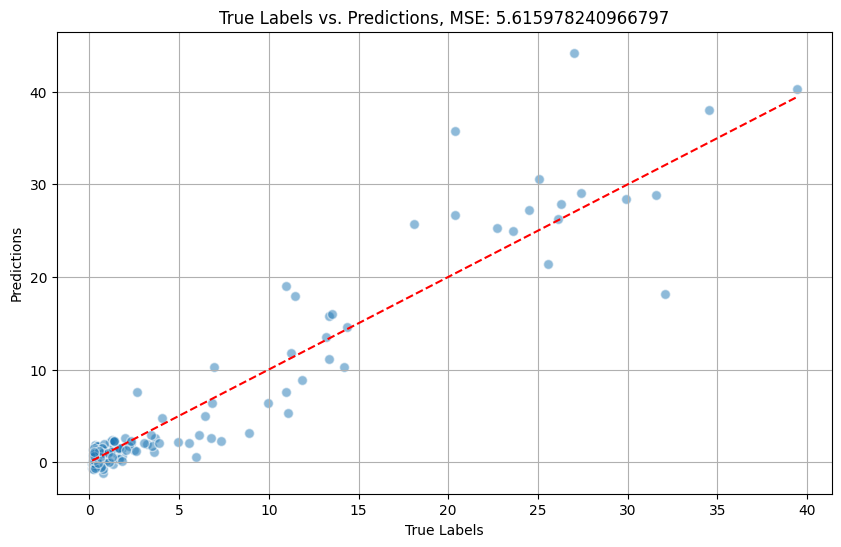

In [77]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

In [83]:
mean_squared_error(all_labels[all_labels<5],all_outputs[all_labels<5])

0.6452869

/tmp/ipykernel_127031/3763736228.py:3: RuntimeWarning: overflow encountered in exp
  mm_all_labels = np.exp(mmscaler.inverse_transform(mm_all_labels))


ValueError: Input contains infinity or a value too large for dtype('float32').

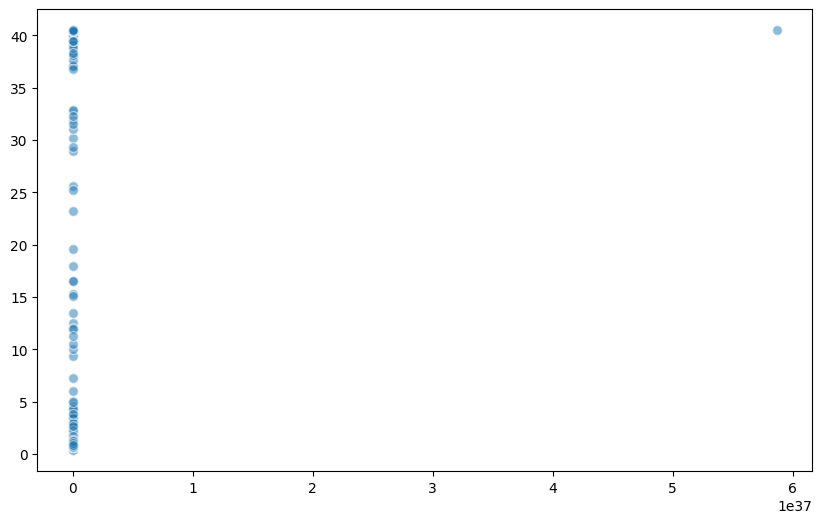

In [70]:
mm_all_labels = np.expand_dims(all_labels,1)

mm_all_labels = np.exp(mmscaler.inverse_transform(mm_all_labels))
mm_all_outputs = np.exp(mmscaler.inverse_transform(all_outputs))

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(mm_all_labels, mm_all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(mm_all_labels), max(mm_all_labels)], [min(mm_all_labels), max(mm_all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(mm_all_labels, mm_all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

In [ ]:
mm_all_labels = np.expand_dims(all_labels,1)

mm_all_labels = np.exp(mmscaler.inverse_transform(mm_all_labels))
mm_all_outputs = np.exp(mmscaler.inverse_transform(all_outputs))

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(mm_all_labels, mm_all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(mm_all_labels), max(mm_all_labels)], [min(mm_all_labels), max(mm_all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(mm_all_labels, mm_all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.ylim([0.15,1])
plt.xlim([0.15,1]);

In [28]:
mean_squared_error(mm_all_labels[mm_all_labels<0.4],mm_all_outputs[mm_all_labels<0.4])

0.015002884

In [29]:
np.mean(mm_all_labels[mm_all_labels<0.4])

0.26428914

#### direct vit base (no freeze)

In [291]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoImageProcessor, ConvNextV2Model
import timm

from sklearn.metrics import mean_squared_error

In [292]:
class ConvNeXtForRegression(nn.Module):
    def __init__(self, base_model):
        super(ConvNeXtForRegression, self).__init__()
        self.backbone = base_model
        # Add a regression head
        self.fc = nn.Linear(base_model.num_features, 1)
        # # Freeze the weights of the backbone
        # for param in self.backbone.parameters():
        #     param.requires_grad = False
            
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return outputs

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = ConvNeXtForRegression(model_base)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [293]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

val_transform = model_transforms

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [294]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'X.csv'))\
    .rename(columns={'avg_rad_min':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target = df_target[['filename','target']]
df_target = df_target.astype({'target':'float32'})

In [295]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [296]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 2m 40s


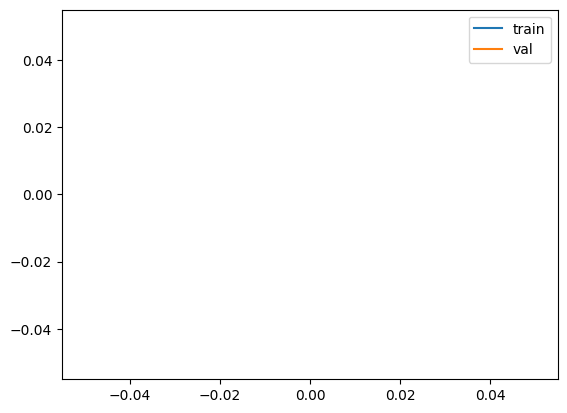

In [297]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

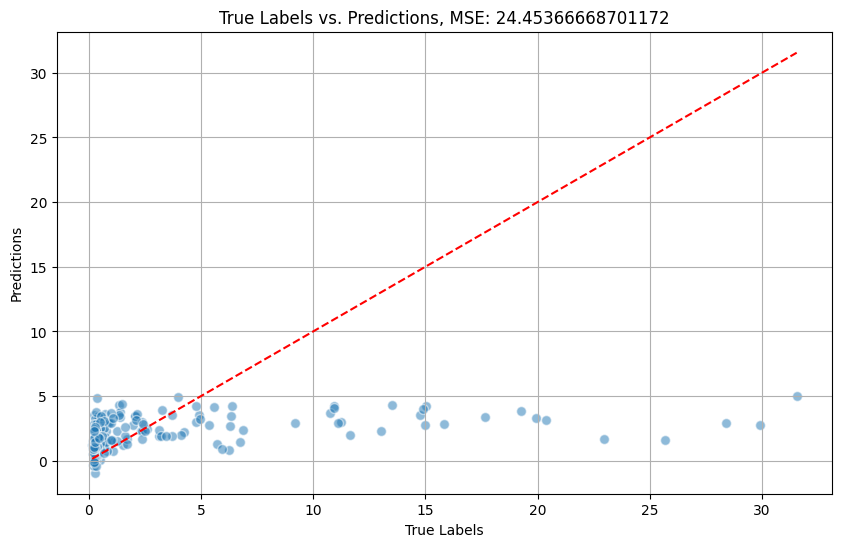

In [298]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])